In [3]:
import timm
import open_clip
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
torch.set_grad_enabled(False)
import psutil
from lavis.models.eva_vit import create_eva_vit_g
from lavis.common.registry import registry
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import gc
import cv2
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def print_mem_stats():
    mem = psutil.virtual_memory()
    total_system_memory = mem.total / (1024 ** 2)
    used_system_memory = mem.used / (1024 ** 2)
    total_gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 2)
    reserved_gpu_memory = torch.cuda.memory_reserved(0) / (1024 ** 2)
    allocated_gpu_memory = torch.cuda.memory_allocated(0) / (1024 ** 2)
    percent_gpu_total = (allocated_gpu_memory / total_gpu_memory)*100
    percent_gpu_reserved = (reserved_gpu_memory / total_gpu_memory)*100
    percent_cpu_total = (used_system_memory / total_system_memory)*100
    print(f"mem used gpu: {allocated_gpu_memory:.2f} MB, reserved gpu: {reserved_gpu_memory:.2f}MB -> {percent_gpu_total:.2f}% of total, {percent_gpu_reserved:.2f}% reserved")
    print(f"mem used cpu: {used_system_memory:.2f} MB -> {percent_cpu_total:.2f}% of total")

print_mem_stats()

mem used gpu: 0.00 MB, reserved gpu: 0.00MB -> 0.00% of total, 0.00% reserved
mem used cpu: 3386.56 MB -> 7.03% of total


In [4]:
import pickle
# use the outputs from step 1
with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

In [4]:
from time import time

visual_encoder_start_time = time()

visual_encoder = create_eva_vit_g(512, precision='fp32').to(gpu_device)

visual_encoder_end_time = time()
print(f"Visual encoder took {visual_encoder_end_time - visual_encoder_start_time} seconds")

Position interpolate from 16x16 to 36x36
Visual encoder took 24.572280883789062 seconds


In [5]:
global_sim_time = time()

cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

# calculate the global feature vector
scene_img = outputs["sceneshotcam"]
print(scene_img.shape)
scene_tensor = torch.tensor(scene_img).permute(2, 0, 1).unsqueeze(0).float().to(gpu_device)

print(scene_tensor.shape)
global_feat = visual_encoder(scene_tensor)
global_feat = global_feat.half()
global_feat = global_feat.mean(1)
global_feat = torch.nn.functional.normalize(global_feat, dim=-1)
FEAT_DIM = global_feat.shape[-1]

global_sim_end_time = time()
print(f"Global feature vector calculation took {global_sim_end_time - global_sim_time} seconds")

(512, 512, 3)
torch.Size([1, 3, 512, 512])
Global feature vector calculation took 1.047487735748291 seconds


In [6]:
import numpy as np

local_sim_time = time()

point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'table', 'ur5e', 'panda']
specific_views = ['panda', 'cereal', 'milk', 'bread', 'apple', 'ur5e', 'banana', 'bin', 'table']#list(set(point_feature_cameras) - {"sceneshotcam"} - {f"genpurp__{i}" for i in range(1,6)})
feat_per_obj = []
obj_sim_per_unit_area = []
for view in tqdm(specific_views):
    obj_img = outputs[view]
    img_roi = torch.tensor(obj_img).permute(2, 0, 1).unsqueeze(0).float().to(gpu_device)
    roifeat = visual_encoder(img_roi)
    roifeat = roifeat.half().cuda()
    roifeat = roifeat.mean(1)
    roifeat = torch.nn.functional.normalize(roifeat, dim=-1)
    feat_per_obj.append(roifeat)

    # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
    _sim = cosine_similarity(global_feat, roifeat)
    obj_sim_per_unit_area.append(_sim)

    torch.cuda.empty_cache()

local_sim_end_time = time()
print(f"Local feature vector calculation took {local_sim_end_time - local_sim_time} seconds")

visual_encoder = None
del visual_encoder
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


Local feature vector calculation took 3.7768161296844482 seconds


In [7]:
score_time = time()

scores = torch.cat(obj_sim_per_unit_area).to(gpu_device)
feat_per_obj = torch.cat(feat_per_obj, dim=0).to(gpu_device)

# get the cosine simixlarity between the features of each object. This will be a square matrix where the (i, j)th entry is the cosine similarity between the ith and jth objects
mask_sim_mat = torch.nn.functional.cosine_similarity(
    feat_per_obj[:, :, None], feat_per_obj.t()[None, :, :]
)
mask_sim_mat_untouched = mask_sim_mat.clone()
mask_sim_mat.fill_diagonal_(0.0) # set the diagonal to 0 because we don't want to consider the similarity between the same object
mask_sim_mat = mask_sim_mat.mean(1)  # avg sim of each mask with each other mask
softmax_scores = scores.cuda() - mask_sim_mat # subtracting the object-object relevance (which can be thought of as the relevance of the object in context of the other objects) object-scene similarity (which is kind of like global relevance) gives how much more or less important that object is than all the other objects
softmax_scores = torch.nn.functional.softmax(softmax_scores, dim=0) # apply softmax to get the final scores

score_end_time = time()
print(f"Score calculation took {score_end_time - score_time} seconds")

print(specific_views)
print(softmax_scores)

Score calculation took 0.0043125152587890625 seconds
['panda', 'cereal', 'milk', 'bread', 'apple', 'ur5e', 'banana', 'bin', 'table']
tensor([0.1115, 0.1098, 0.1115, 0.1118, 0.1106, 0.1111, 0.1110, 0.1118, 0.1111],
       device='cuda:0', dtype=torch.float16)


In [9]:
torch.save(mask_sim_mat_untouched, "figure_data/blip_noneva_rendfet_sim_square.pt")

In [8]:
pixelwise_start_time = time()

pixelwise_features = torch.zeros(outputs['xyz_pts'].shape[0], FEAT_DIM, dtype=torch.half)
pixelwise_features = pixelwise_features.to(gpu_device)
for objidx in range(len(specific_views)):
    _weighted_feat = (
        softmax_scores[objidx] * global_feat + (1 - softmax_scores[objidx]) * feat_per_obj[objidx]
    )
    _weighted_feat = torch.nn.functional.normalize(_weighted_feat, dim=-1)
    pixelwise_features[outputs['segmentation_pts'][specific_views[objidx]], :] = _weighted_feat
    # second normalization is unnecessary because all pixels in each object receive the same feature, and each point is only interacted with once.
    # instead, we will normalize the features after voxel aggregation

pixelwise_end_time = time()
print(f"Pixelwise feature calculation took {pixelwise_end_time - pixelwise_start_time} seconds")

print_mem_stats()

Pixelwise feature calculation took 1.4797210693359375 seconds
mem used gpu: 5007.87 MB, reserved gpu: 5042.00MB -> 22.27% of total, 22.42% reserved
mem used cpu: 3572.83 MB -> 7.41% of total


- It has been helpful to keep track of this metric to know when I've done something that messed up the feature extraction pipeline.

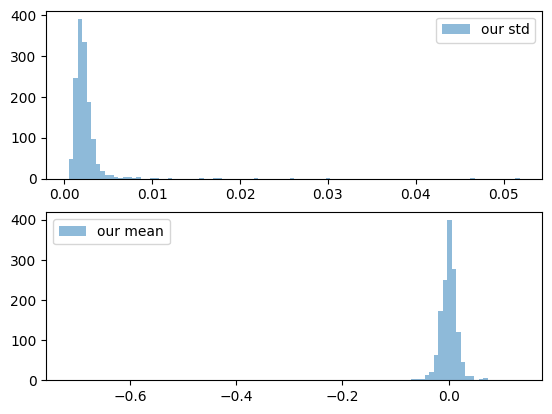

In [10]:
our_std = torch.std(pixelwise_features, dim=0)
our_mean = torch.mean(pixelwise_features, dim=0)
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2)
axs[0].hist(our_std.cpu().numpy(), bins=100, alpha=0.5, label="our std")
axs[0].legend()
axs[1].hist(our_mean.cpu().numpy(), bins=100, alpha=0.5, label="our mean")
axs[1].legend()
plt.show()

In [9]:
# we have to save the pixelwise features as a tensor so that we can do the voxel grid sampling
# unfortunately, that doesn't work with the version of pytorch that we use this notebook
# WIP
torch.save(pixelwise_features.cpu(), "blip_noneva_pixelwise_rendfet_features.pt")